In [268]:
import arviz as az
import theano.tensor as tt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow_probability as tfp
from scipy.stats import invwishart, invgamma
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100



In [269]:
dta = pd.read_csv('Reco_HH_14Days.csv')

dta[['TIMESTAMP_START']] = (dta[['TIMESTAMP_START']].applymap(str).applymap(
    lambda s: "{}/{}/{} {}:{}".format(s[0:4], s[4:6], s[6:8], s[8:10], s[10:12])))

dta['TIMESTAMP_START'] = dta['TIMESTAMP_START'].astype('datetime64[ns]')

#mask = (dta['TIMESTAMP_START'] > '2005-05-01') & (dta['TIMESTAMP_START'] <= '2005-05-14')

dta.set_index(['TIMESTAMP_START'], inplace=True)

#dta = dta.resample('1H').mean()

dta.reset_index(inplace=True)

dta.columns






Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F', 'TA_F_QC', 'SW_IN_POT',
       'SW_IN_F', 'SW_IN_F_QC', 'LW_IN_F', 'LW_IN_F_QC', 'VPD_F', 'VPD_F_QC',
       'PA_F', 'PA_F_QC', 'P_F', 'P_F_QC', 'WS_F', 'WS_F_QC', 'WD', 'USTAR',
       'RH', 'NETRAD', 'PPFD_IN', 'PPFD_DIF', 'SW_OUT', 'LW_OUT', 'CO2_F_MDS',
       'CO2_F_MDS_QC', 'TS_F_MDS_1', 'TS_F_MDS_1_QC', 'G_F_MDS', 'G_F_MDS_QC',
       'LE_F_MDS', 'LE_F_MDS_QC', 'LE_CORR', 'LE_CORR_25', 'LE_CORR_75',
       'LE_RANDUNC', 'H_F_MDS', 'H_F_MDS_QC', 'H_CORR', 'H_CORR_25',
       'H_CORR_75', 'H_RANDUNC', 'NIGHT', 'NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_VUT_REF_RANDUNC', 'NEE_VUT_25', 'NEE_VUT_50', 'NEE_VUT_75',
       'NEE_VUT_25_QC', 'NEE_VUT_50_QC', 'NEE_VUT_75_QC', 'RECO_NT_VUT_REF',
       'RECO_NT_VUT_25', 'RECO_NT_VUT_50', 'RECO_NT_VUT_75', 'GPP_NT_VUT_REF',
       'GPP_NT_VUT_25', 'GPP_NT_VUT_50', 'GPP_NT_VUT_75', 'RECO_DT_VUT_REF',
       'RECO_DT_VUT_25', 'RECO_DT_VUT_50', 'RECO_DT_VUT_75', 'GPP_DT_VUT_REF',
       'GPP

In [270]:
def norm(data):
    norm_data = (data-np.max(data))/(np.min(data)-np.max(data))
    return norm_data

In [271]:
ts = pd.DataFrame(dta.loc[:,['TIMESTAMP_START', 'TA_F','SW_IN_F','RECO_NT_VUT_50']])
reco = norm(ts['RECO_NT_VUT_50'])
temp = norm(ts['TA_F'])
len(ts)

672

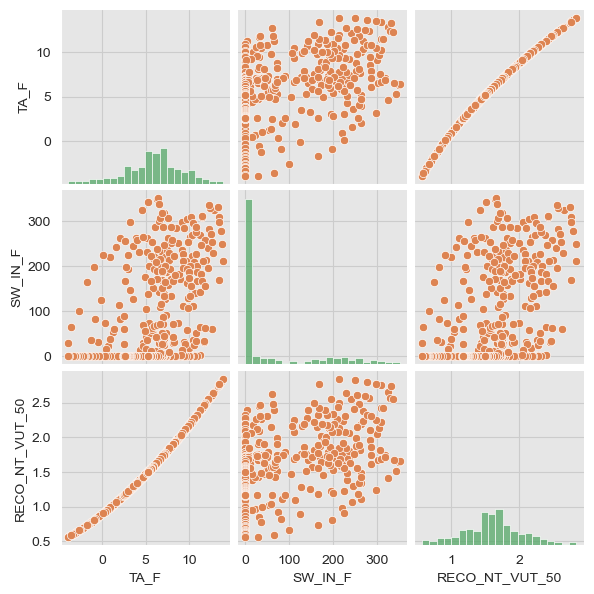

In [292]:
sns.pairplot(
    data=ts,
    kind="scatter",
    height=2,
    plot_kws={"color": sns_c[1]},
    diag_kws={"color": sns_c[2]}
)

In [272]:
num_forecast = 48 * 2  # two days
data_training = ts[:-num_forecast]
data_test = ts[-num_forecast:]
#data_training
data_training['TIMESTAMP_START'].tail(1)


575   2000-01-12 23:30:00
Name: TIMESTAMP_START, dtype: datetime64[ns]

[Text(0.5, 1.0, 'Sample Data - Train Test Split')]

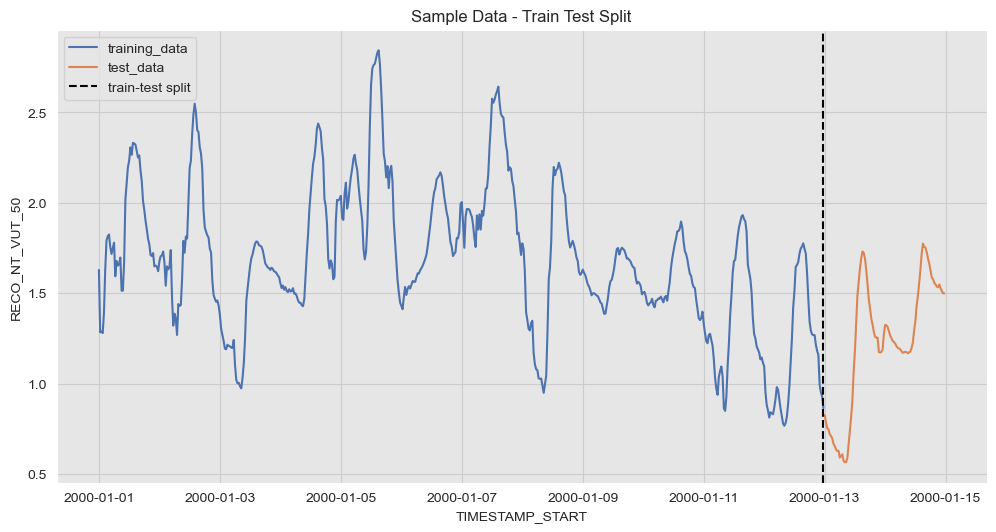

In [273]:
fig, ax = plt.subplots()
sns.lineplot(x=data_training['TIMESTAMP_START'], y=data_training['RECO_NT_VUT_50'], data=data_training, color=sns_c[0], label='training_data', ax=ax)
sns.lineplot(x=data_test['TIMESTAMP_START'], y=data_test['RECO_NT_VUT_50'], data=data_test, color=sns_c[1], label='test_data', ax=ax)
ax.axvline(x=data_training['TIMESTAMP_START'].tail(1), color='black', linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='Sample Data - Train Test Split')

[Text(0.5, 1.0, 'y ~ $x_2$ (training data)')]

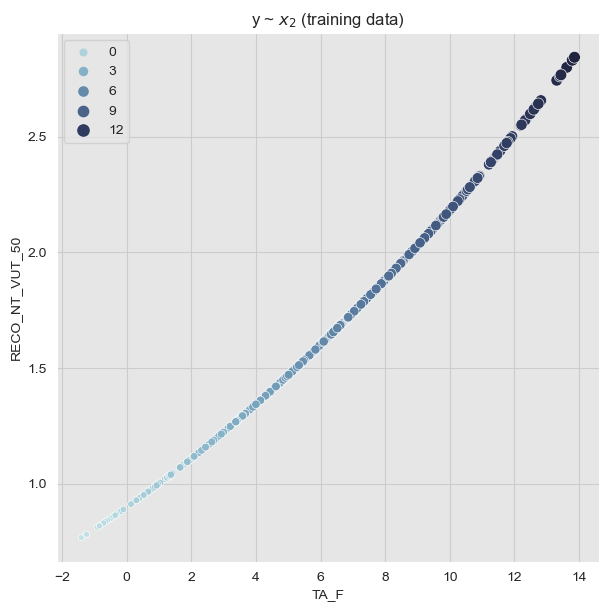

In [275]:
fig, ax = plt.subplots(figsize=(7, 7))

cmap = sns.cubehelix_palette(rot=-0.2, as_cmap=True)

sns.scatterplot(
    x=data_training['TA_F'],
    y=data_training['RECO_NT_VUT_50'], 
    hue='TA_F', 
    size='TA_F',
    palette=cmap, 
    edgecolor='white', 
    data=data_training, 
    ax=ax
)
ax.legend(loc='upper left')
ax.set(title=r'y ~ $x_2$ (training data)')

[Text(0.5, 1.0, 'Correlarion Matrix (training data)')]

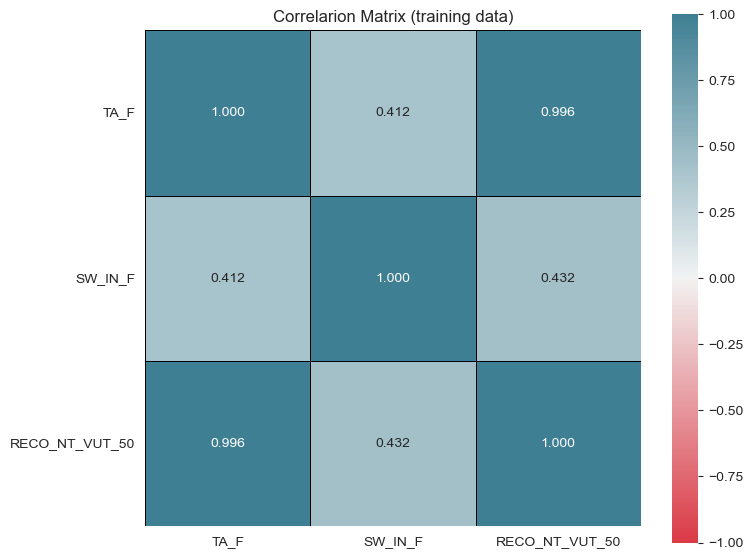

In [276]:
corr_mat = data_training.drop('TIMESTAMP_START', axis=1).corr()

fig, ax = plt.subplots(figsize=(8, 7))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(
    data=corr_mat, 
    vmin=-1.0, 
    vmax=1.0, 
    center=0, 
    cmap=cmap, 
    square=True,
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_yticklabels(), horizontalalignment='center')
ax.set(title='Correlarion Matrix (training data)')

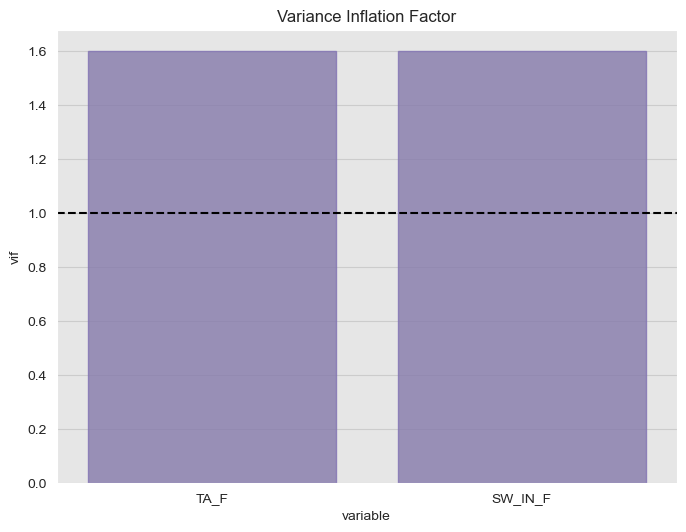

In [277]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#'TIMESTAMP_START', 'TA_F','SW_IN_F','RECO_NT_VUT_50'
X_train = data_training.drop(['RECO_NT_VUT_50', 'TIMESTAMP_START'], axis=1)

vif_df = pd.DataFrame(
    data= [ 
        (c, variance_inflation_factor(exog=X_train.to_numpy(), exog_idx=i)) 
        for i, c in enumerate(X_train.columns)
    ], 
    columns=['variable', 'vif']
)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    x='variable', 
    y='vif', 
    color=sns_c[4],
    edgecolor=sns_c[4],
    alpha=0.8,
    dodge=False,
    data=vif_df, 
    ax=ax
)

ax.axhline(y=1, color='black', linestyle='--')
ax.set(title='Variance Inflation Factor');

[Text(0.5, 1.0, 'Dependent Variable - Smoothing'), Text(0, 0.5, 'y')]

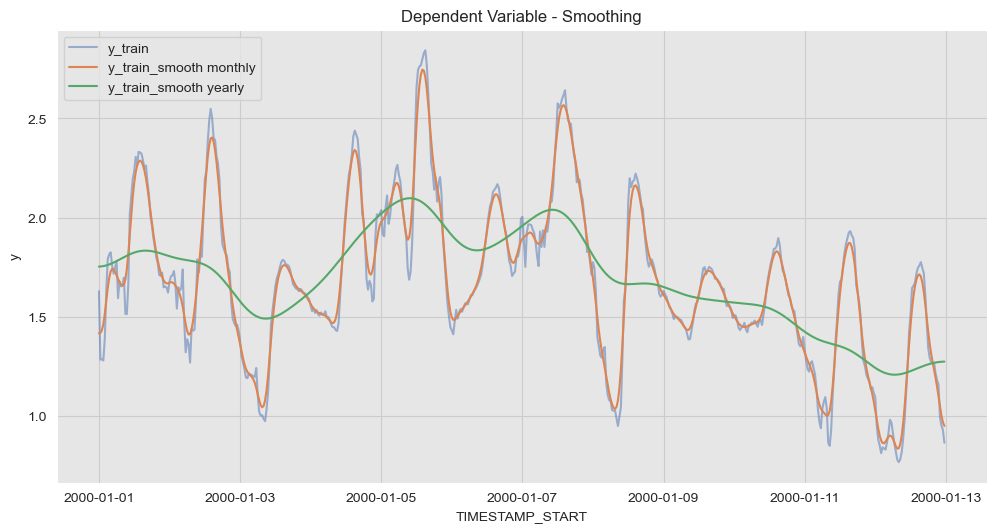

In [278]:
from scipy.ndimage import gaussian_filter

df_smooth = data_training \
    .assign(y_smooth_1 = lambda x: gaussian_filter(input=data_training['RECO_NT_VUT_50'], sigma=2.5)) \
    .assign(y_smooth_2 = lambda x: gaussian_filter(input=data_training['RECO_NT_VUT_50'], sigma=20)) \

fig, ax = plt.subplots()
sns.lineplot(x='TIMESTAMP_START', y=data_training['RECO_NT_VUT_50'], label='y_train', data=df_smooth, alpha=0.5, ax=ax)
sns.lineplot(x='TIMESTAMP_START', y='y_smooth_1', label='y_train_smooth monthly', data=df_smooth, ax=ax)
sns.lineplot(x='TIMESTAMP_START', y='y_smooth_2', label='y_train_smooth yearly', data=df_smooth, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dependent Variable - Smoothing', ylabel='y')

[Text(0.5, 1.0, 'y no year & month seasonality')]

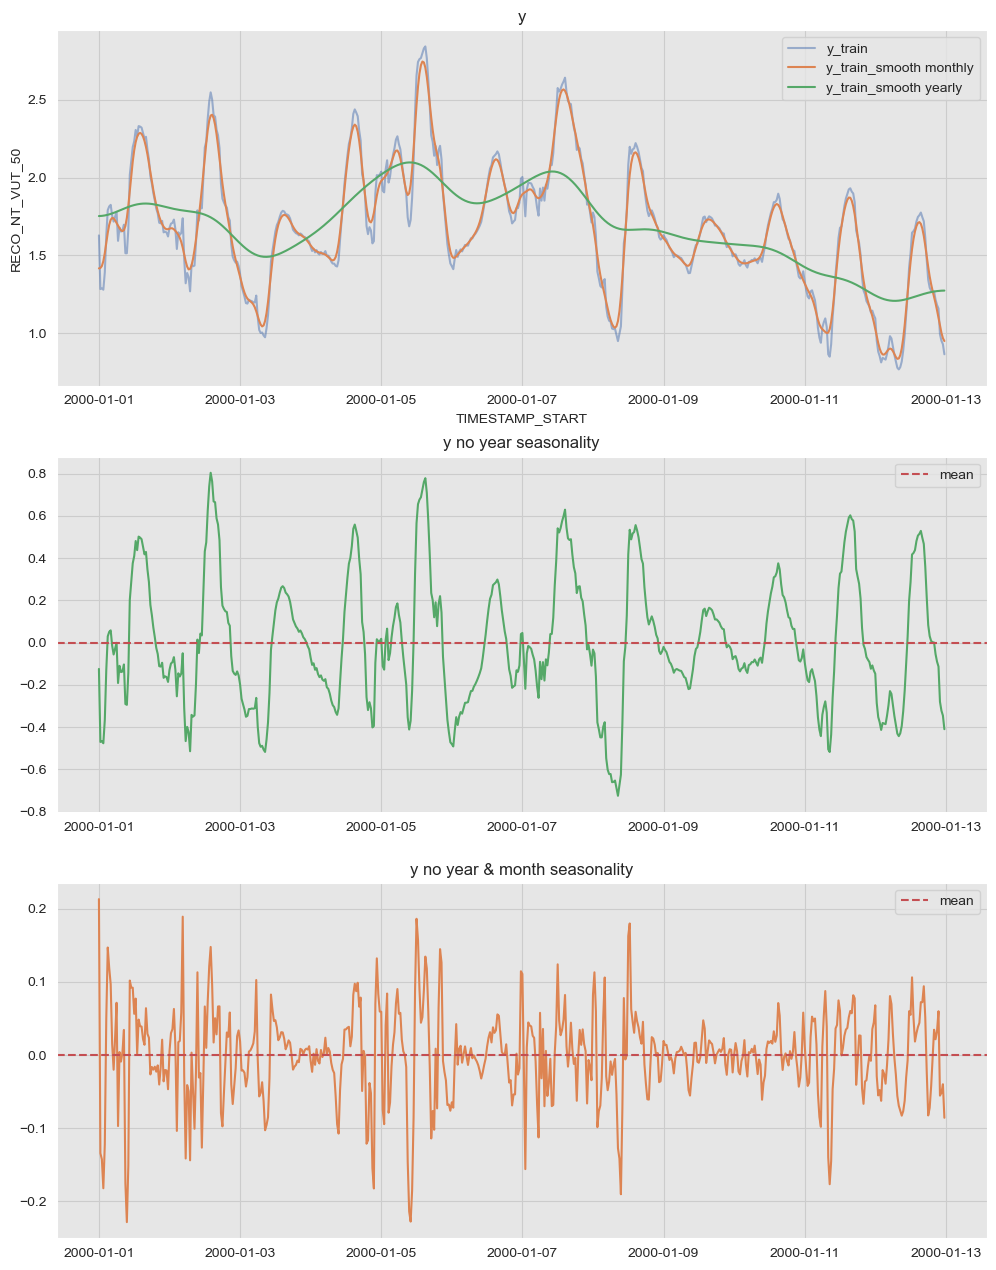

In [279]:
# Remove yearly seasonality.
y_no_year_season = df_smooth['RECO_NT_VUT_50'] - df_smooth['y_smooth_2']
# Remove monthly seasonality.
y_no_year_month_season = y_no_year_season \
    - gaussian_filter(input=y_no_year_season, sigma=2.5)

# Plot components.
fig, ax = plt.subplots(3, 1, figsize=(12, 16))
sns.lineplot(x='TIMESTAMP_START', y=data_training['RECO_NT_VUT_50'], label='y_train', data=df_smooth, alpha=0.5, ax=ax[0])
sns.lineplot(x='TIMESTAMP_START', y='y_smooth_1', label='y_train_smooth monthly', data=df_smooth, ax=ax[0])
sns.lineplot(x='TIMESTAMP_START', y='y_smooth_2', label='y_train_smooth yearly', data=df_smooth, ax=ax[0])
ax[0].set(title='y')

ax[1].plot(df_smooth['TIMESTAMP_START'], y_no_year_season, c=sns_c[2])
ax[1].axhline(y_no_year_season.mean(), color=sns_c[3], linestyle='--', label='mean')
ax[1].legend()
ax[1].set(title='y no year seasonality')

ax[2].plot(df_smooth['TIMESTAMP_START'], y_no_year_month_season, c=sns_c[1])
ax[2].axhline(y_no_year_month_season.mean(), color=sns_c[3], linestyle='--', label='mean')
ax[2].legend()
ax[2].set(title='y no year & month seasonality')

/Users/sabazamankhani/miniforge3/envs/pymc3_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


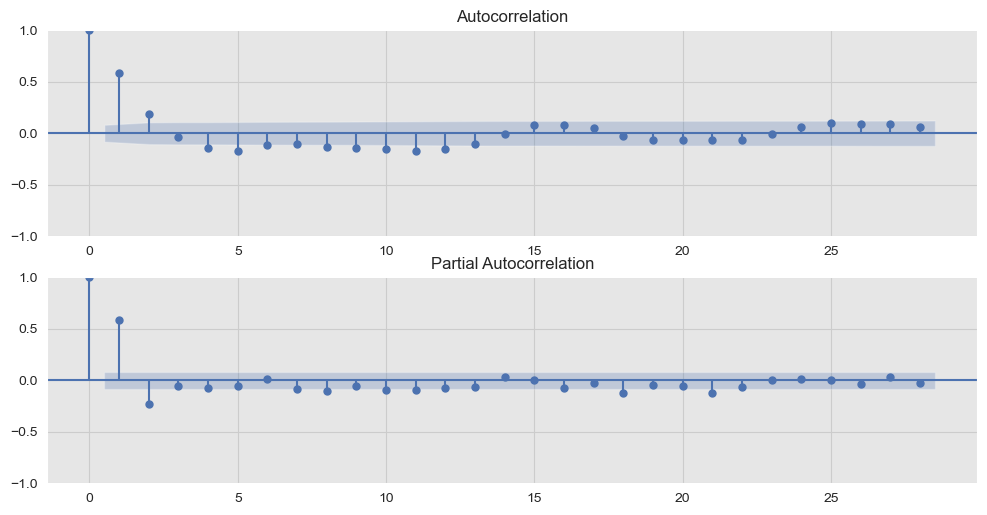

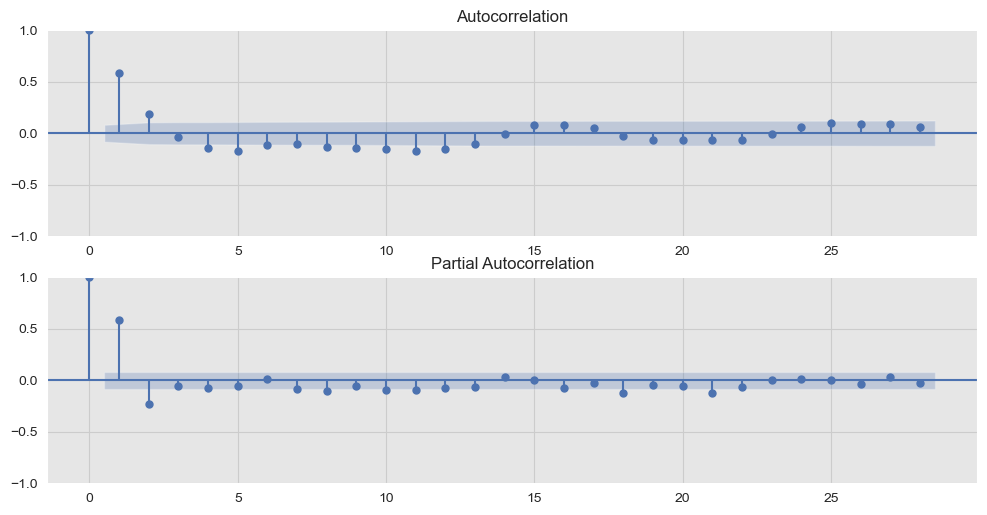

In [280]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1)
plot_acf(x=y_no_year_month_season, ax=ax[0])
plot_pacf(x=y_no_year_month_season, ax=ax[1])

In [282]:

#'TIMESTAMP_START', 'TA_F','SW_IN_F','RECO_NT_VUT_50'
target_variable = ['RECO_NT_VUT_50']

date_features = ['TIMESTAMP_START']

numeric_features = ['TA_F', 'SW_IN_F']

preprocesser = ColumnTransformer(
    transformers=[('std', StandardScaler(), numeric_features)]
)
preprocesser.fit(data_training)

# Scale training data.
data_train_scaled_df = pd.DataFrame(
    data=preprocesser.transform(data_training),
    columns=numeric_features
)
data_train_scaled_df['RECO_NT_VUT_50'] = data_training['RECO_NT_VUT_50'] 

# Scale test data.
data_test_scaled_df = pd.DataFrame(
    data=preprocesser.transform(data_test),
    columns=numeric_features
)
data_test_scaled_df['RECO_NT_VUT_50'] = data_training['RECO_NT_VUT_50']

In [284]:
model_formula = 'RECO_NT_VUT_50 ~ TA_F + SW_IN_F'
model = smf.ols(model_formula, data=data_train_scaled_df)
result = model.fit()
# Print linear model stats.
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         RECO_NT_VUT_50   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.731e+04
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:05:49   Log-Likelihood:                 1106.4
No. Observations:                 576   AIC:                            -2207.
Df Residuals:                     573   BIC:                            -2194.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6821      0.001   1136.048      0.0

In [286]:
#'TIMESTAMP_START', 'TA_F','SW_IN_F','RECO_NT_VUT_50'
# Predictions on the training set.
train_pred_df = result.get_prediction(data_train_scaled_df).summary_frame()
train_pred_df.columns = 'pred_' + train_pred_df.columns
train_pred_df = pd.concat([data_training, train_pred_df], axis=1)
train_pred_df = train_pred_df.assign(
    error = lambda x: x['pred_mean'] - x['RECO_NT_VUT_50'],
    abs_error = lambda x: x['error'].abs(),
    p_error = lambda x: x['error'].div(x['RECO_NT_VUT_50'])
)
# Predictions on the test set.
test_pred_df = result.get_prediction(data_test_scaled_df).summary_frame()
test_pred_df.columns = 'pred_' + test_pred_df.columns
test_pred_df = pd.concat([data_test.reset_index(drop=True), test_pred_df], axis=1)
test_pred_df = test_pred_df.assign(
    error = lambda x: x['pred_mean'] - x['RECO_NT_VUT_50'],
    abs_error = lambda x: x['error'].abs(),
    p_error = lambda x: x['error'].div(x['RECO_NT_VUT_50'])
)
# Concatenate predictions.
pred_df = pd.concat(
    [train_pred_df.assign(tag='train'), test_pred_df.assign(tag='test')], 
    axis=0
)

[Text(0.5, 1.0, 'Linear Model Prediction (train-Test Split)'),
 Text(0, 0.5, 'RECO_NT_VUT_50')]

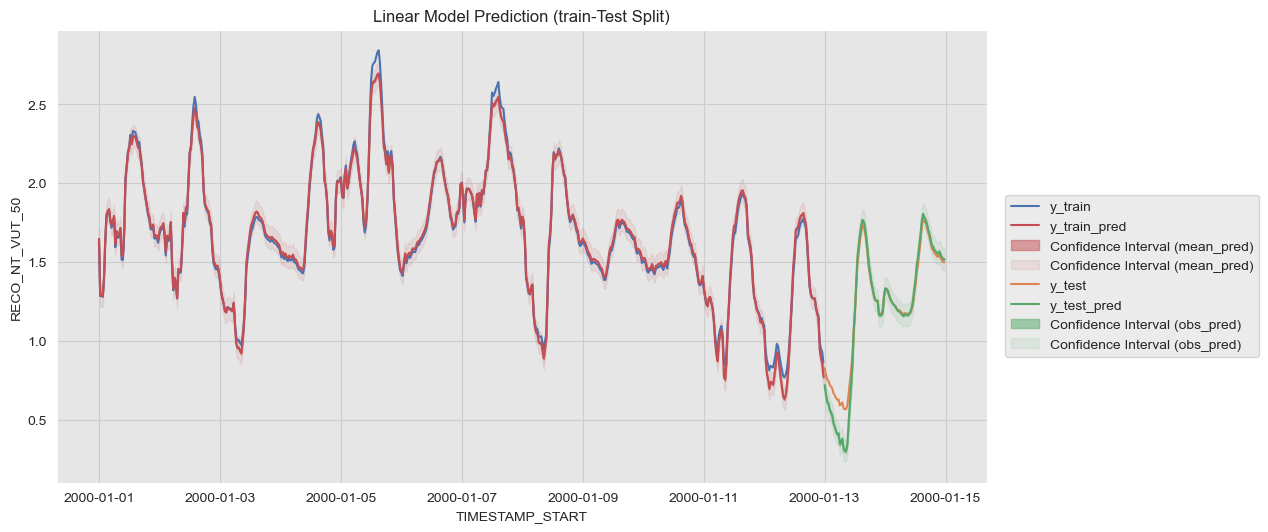

In [290]:
fig, ax = plt.subplots()
sns.lineplot(x='TIMESTAMP_START', y='RECO_NT_VUT_50', data=train_pred_df, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x='TIMESTAMP_START', y='pred_mean', data=train_pred_df, color=sns_c[3], label='y_train_pred', ax=ax)
ax.fill_between(
    x=train_pred_df['TIMESTAMP_START'],
    y1=train_pred_df['pred_mean_ci_lower'],
    y2=train_pred_df['pred_mean_ci_upper'],
    color=sns_c[3], 
    alpha=0.5,
    label='Confidence Interval (mean_pred)'
)
ax.fill_between(
    x=train_pred_df['TIMESTAMP_START'],
    y1=train_pred_df['pred_obs_ci_lower'],
    y2=train_pred_df['pred_obs_ci_upper'],
    color=sns_c[3], 
    alpha=0.10,
    label='Confidence Interval (mean_pred)'
)
sns.lineplot(x='TIMESTAMP_START', y='RECO_NT_VUT_50', data=test_pred_df, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x='TIMESTAMP_START', y='pred_mean', data=test_pred_df, color=sns_c[2], label='y_test_pred', ax=ax)
ax.fill_between(
    x=test_pred_df['TIMESTAMP_START'],
    y1=test_pred_df['pred_mean_ci_lower'],
    y2=test_pred_df['pred_mean_ci_upper'],
    color=sns_c[2], 
    alpha=0.5,
    label='Confidence Interval (obs_pred)'
)
ax.fill_between(
    x=test_pred_df['TIMESTAMP_START'],
    y1=test_pred_df['pred_obs_ci_lower'],
    y2=test_pred_df['pred_obs_ci_upper'],
    color=sns_c[2], 
    alpha=0.10,
    label='Confidence Interval (obs_pred)'
)
ax.legend(bbox_to_anchor=(1.3, 0.65))
ax.set(title='Linear Model Prediction (train-Test Split)', ylabel='RECO_NT_VUT_50')

Text(0.5, 0.94, 'Linear Model Errors Distribution')

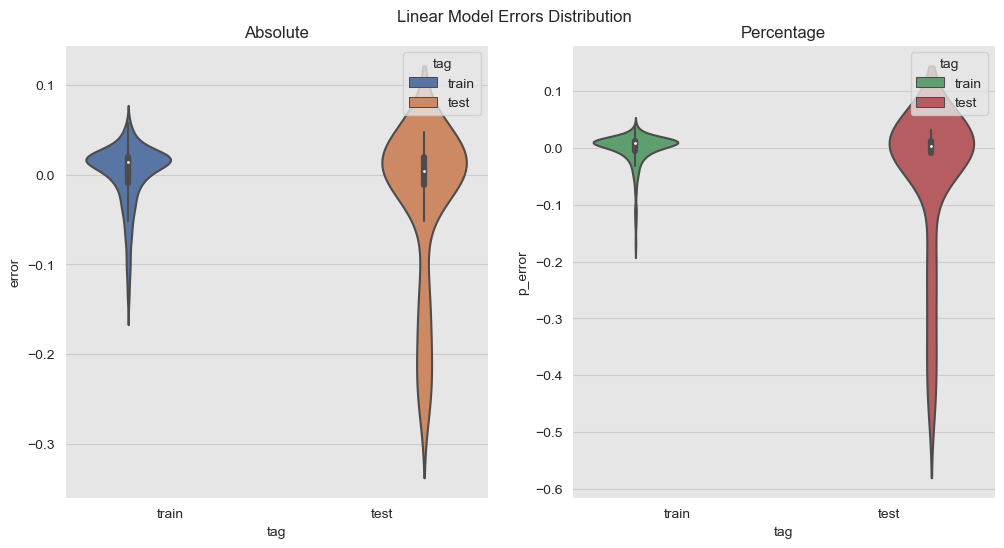

In [291]:
fig, ax = plt.subplots(1, 2)
sns.violinplot(x='tag', y='error', data=pred_df, hue='tag', palette=[sns_c[0], sns_c[1]], ax=ax[0])
sns.violinplot(x='tag', y='p_error', data=pred_df, hue='tag', palette=[sns_c[2], sns_c[3]], ax=ax[1])
ax[0].set(title='Absolute')
ax[1].set(title='Percentage')
plt.suptitle(f'Linear Model Errors Distribution', y=0.94)


/Users/sabazamankhani/miniforge3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [ ]:
_, ax = plt.subplots(1,1,figsize=(12,5))
time = np.arange(0,len(y))

ax.plot(time, ppc['level'].T[:,1:], alpha=0.8, color='b', label='_')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))


ax.plot(time,ppc['level'].T[:,1],alpha=0.8, color='b', label='Samples from our posterior distribution')
ax.plot(y, color='darkorange', label='data')
ax.legend()

In [ ]:
with m2:
    ppc = pm.sample_posterior_predictive(trace, 800)

In [ ]:


colors = sns.color_palette()
c1, c2, c3 = colors[0], colors[1], colors[2]

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ts['TIMESTAMP_START'],
        reco, lw=2, c=c1)
ax.set_ylabel("reco")


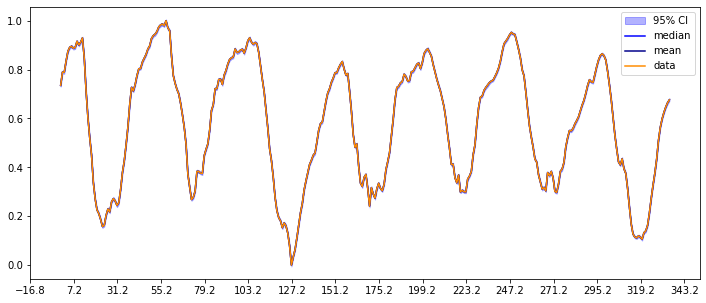

In [53]:
CI = np.percentile(ppc['level'], axis=0, q=[2.5, 50, 97.5])

mean = np.mean(ppc['level'], axis=0)

_, ax = plt.subplots(1, 1, figsize=(12,5))
ax.fill_between(time,CI[0], CI[2] ,alpha=0.3, color='b', label='95% CI')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))
ax.plot(CI[1], color='b', label='median')
ax.plot(mean, color='darkblue', label='mean')
ax.plot(y, color='darkorange', label='data')
ax.legend()